导入库

In [1]:
import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

配置参数

In [2]:
#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#图像尺寸
IMAGE_SIZE_MNIST = 28
#隐变量维度
dim_z=3
#alpha classification loss balance
alpha=100
#隐层节点数
n_hidden=500
#学习率
learn_rate=1e-3
#训练轮数
n_epochs=50
#批量数目
batch_size=256
#标签样式 one-hot编码
one_hot=np.eye(10)
#结果保存路径
path=os.path.join(os.getcwd(),'result_refine')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
#是否加入噪声，denoise vae
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
#beta-vae
beta=2.0

#画图
PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=False
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

准备target domain 数据

In [3]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()

W0917 16:47:19.604927 140009940297536 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/mnist_data.py:30: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:

""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')
x_label=tf.placeholder(tf.float32, shape=[None, 10], name='img_label')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, cost, neg_marginal_likelihood, KL_divergence,SigMa = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)
z_tmp=tf.layers.Dense(10)(z)
z_class=tf.nn.softmax(z_tmp)
# print(z_cl)
classifation_loss=tf.reduce_mean(x_label * tf.log(z_class) + (1 - x_label) * tf.log(1 - z_class))
# network architecture beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)
loss=cost-alpha*classifation_loss
# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)

W0917 16:47:20.537425 140009940297536 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:5: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0917 16:47:21.627839 140009940297536 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0917 16:47:21.629189 140009940297536 deprecation_wrapper.py:119] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:11: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0917 16:47:21.644551 140009940297536 deprecation.py:506] From /home/yuemei.zhu/tensorflow-mnist-VAE/vae.py:15: calling dropout (from tensorflow.python.ops.nn_op

In [5]:
np.random.seed(100)
n_samples=train_size

""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
sess=tf.Session()
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
    np.random.shuffle(train_total_data)
    train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS]
    train_label_= train_total_data[:, -mnist_data.NUM_LABELS:]
    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]
        batch_xs_label = train_label_[offset:(offset + batch_size), :]
        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence,class_loss,Sigma= sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence,classifation_loss,SigMa),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, x_label:batch_xs_label,keep_prob : 0.9})

    # print cost every epoch
    print(Sigma.mean(axis=0))
    print(Sigma.max(axis=0))
    print(Sigma.min(axis=0))
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f classifation_loss %03.2f " % (epoch, tot_loss, loss_likelihood, loss_divergence,class_loss))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")


[0.24389121 0.2295511  0.19990465 0.21370816 0.22615486]
[0.65173423 0.5515676  0.74338776 0.55074334 0.4591744 ]
[0.08678017 0.08089717 0.08385824 0.05827233 0.09306353]
epoch 0: L_tot 188.71 L_likelihood 154.46 L_divergence 11.62 classifation_loss -0.23 
[0.19057399 0.16513045 0.21713415 0.08687144 0.21401463]
[0.41559073 0.4371177  0.62236595 0.41157305 0.46851745]
[0.04748521 0.04416225 0.06655534 0.00178623 0.08650087]
epoch 1: L_tot 177.28 L_likelihood 143.83 L_divergence 15.15 classifation_loss -0.18 
[0.21103993 0.19454661 0.21018416 0.18064255 0.20145722]
[0.5550377  0.5670953  0.51371175 0.42273846 0.45267105]
[0.06982551 0.05675554 0.08155619 0.06384385 0.08844212]
epoch 2: L_tot 160.00 L_likelihood 134.19 L_divergence 12.97 classifation_loss -0.13 
[0.1816442  0.1607826  0.2072752  0.18131675 0.15767555]
[0.4124089  0.34127307 0.42631817 0.43067273 0.40505412]
[0.03918408 0.07174301 0.0668687  0.06205914 0.05314751]
epoch 3: L_tot 157.28 L_likelihood 132.84 L_divergence 14.

[0.13615099 0.11708289 0.12221367 0.12181102 0.11985455]
[0.30691317 0.20870091 0.2942093  0.23906247 0.27946568]
[0.07426631 0.06381679 0.06972812 0.06244817 0.05106633]
epoch 32: L_tot 125.60 L_likelihood 110.69 L_divergence 12.81 classifation_loss -0.02 
[0.12742858 0.11295863 0.12549913 0.10710853 0.11977017]
[0.2882758  0.1879504  0.2691209  0.18063934 0.24444517]
[0.07992875 0.05247323 0.06832905 0.06352227 0.06738748]
epoch 33: L_tot 126.80 L_likelihood 110.09 L_divergence 12.98 classifation_loss -0.04 
[0.12962332 0.1061985  0.11874432 0.11834415 0.12593433]
[0.3367123  0.19960457 0.2519319  0.20270284 0.26631472]
[0.07725774 0.0502426  0.05538375 0.073396   0.07341251]
epoch 34: L_tot 128.55 L_likelihood 113.43 L_divergence 12.67 classifation_loss -0.02 
[0.13119744 0.11372665 0.11556414 0.12527202 0.1174108 ]
[0.33816397 0.25245085 0.2421407  0.21618652 0.25610405]
[0.05499445 0.05498948 0.05391464 0.07954779 0.06146024]
epoch 35: L_tot 124.59 L_likelihood 110.14 L_divergence

[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 75: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 76: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 77: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 78: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 79: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 80: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
epoch 81: L_tot nan L_likelihood nan L_divergence nan classifation_loss nan 

选定一个类别，准备数据

例如：针对类别3，将训练集数据中类别3的样本组成数组

target domain 5444


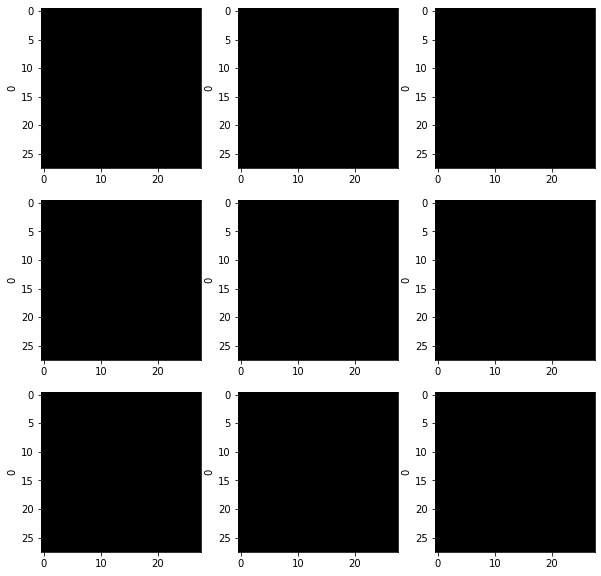

target domain 6179


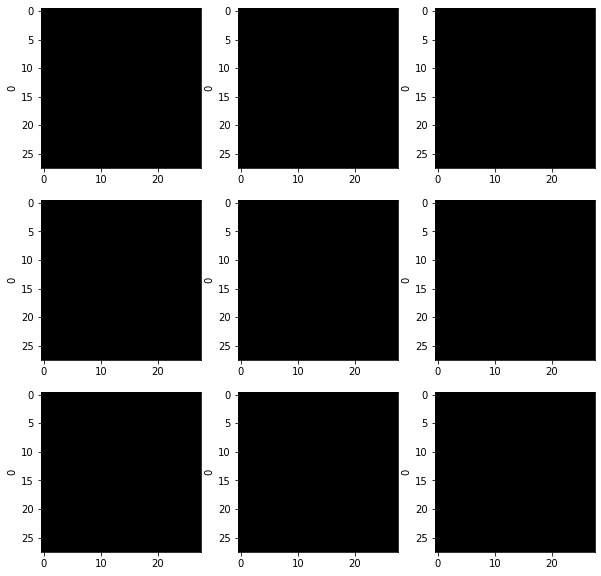

target domain 5470


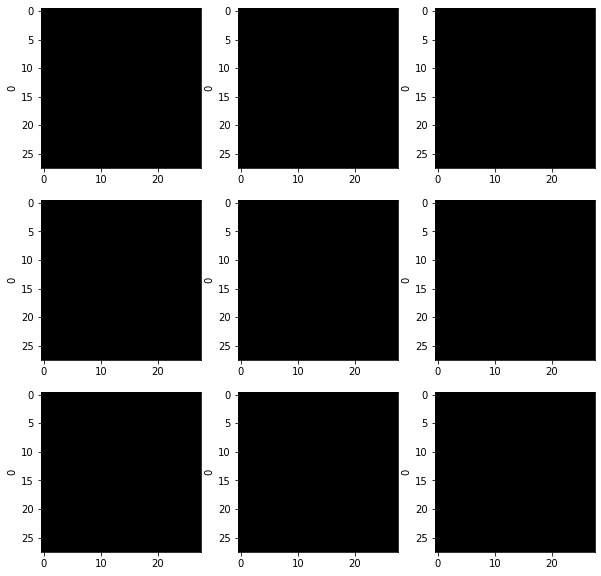

target domain 5638


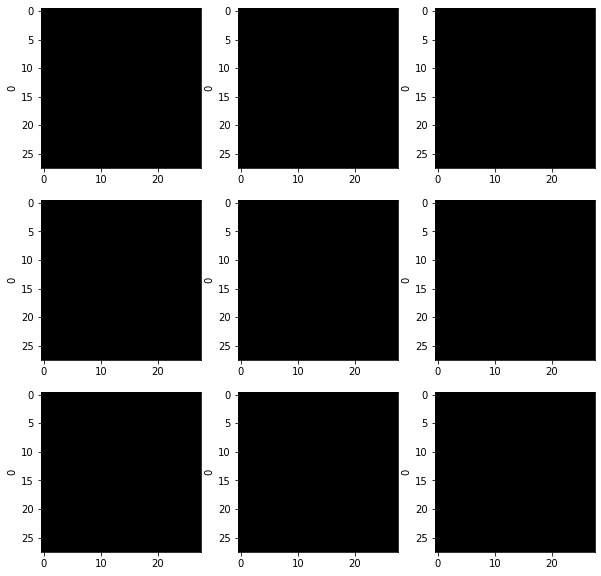

target domain 5307


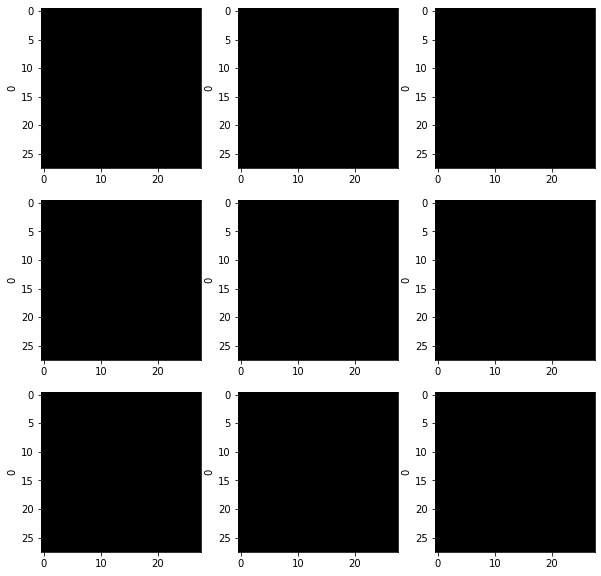

target domain 4987


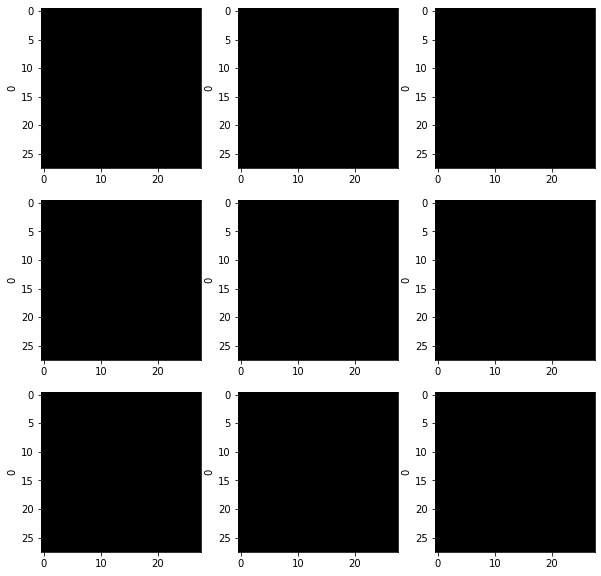

target domain 5417


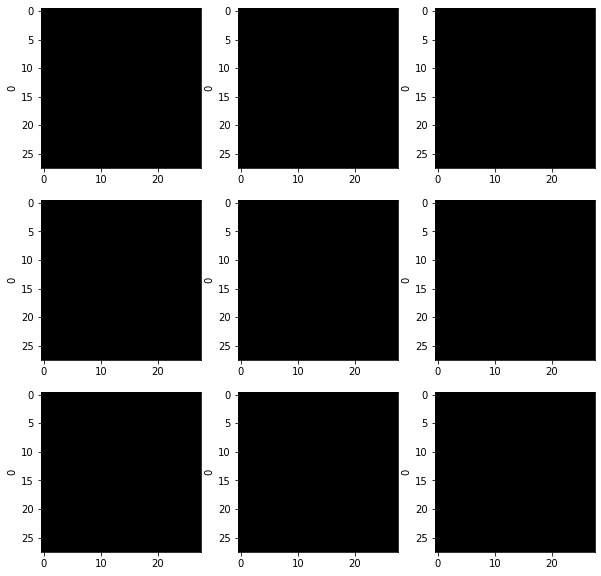

target domain 5715


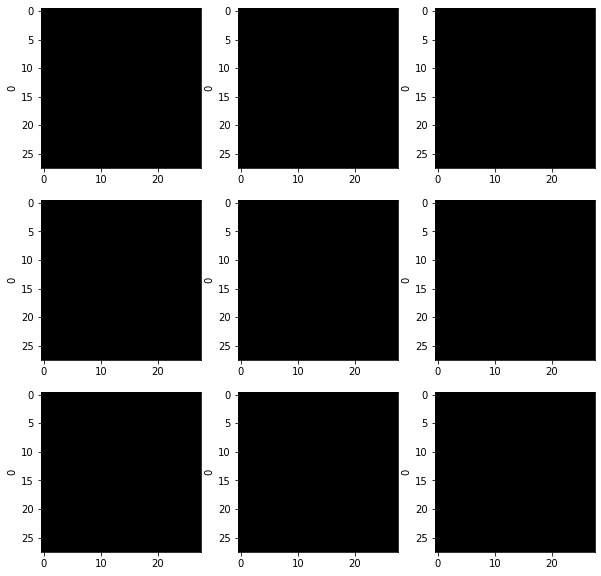

target domain 5389


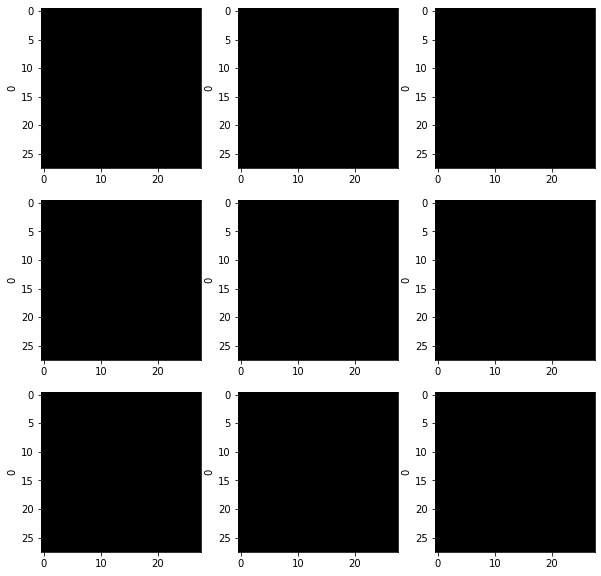

target domain 5454


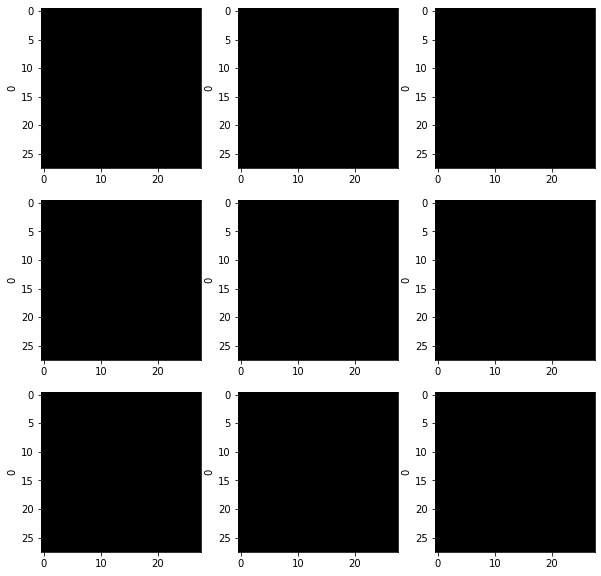

In [6]:
for choose_c in range(10):
    c=0
    for p in range(train_total_data.shape[0]):
        if np.argmax(train_total_data[p,-10:])==choose_c:
            c+=1

    target_domain_size=c
    print('target domain',target_domain_size)

    k3=np.zeros([target_domain_size,784])
    c=0
    for p in range(train_total_data.shape[0]):
        if np.argmax(train_total_data[p,-10:])==choose_c:
            k3[c]=train_total_data[p,:-10]
            c+=1
    #         if c == 10:
    #             print('target domain test count')
    #             plt.imshow(train_total_data[p,:-10].reshape([28,28]))
    #             plt.show()
    #设置batch size
    target_batch = int(target_domain_size / batch_size)

    #同一类别的隐变量
    vec_ari_a=np.zeros([target_batch*batch_size,dim_z])
    for offset in range(target_batch):
        x_batch=k3[offset*batch_size:(offset+1)*batch_size]
        z_batch = sess.run(z, feed_dict={x_hat: x_batch, keep_prob : 1})
        vec_ari_a[offset*batch_size:(offset+1)*batch_size]=z_batch
    mu_,sigma_=vec_ari_a.mean(axis=0),vec_ari_a.std(axis=0)

    c=0
    plt.figure(figsize=(10,10))
    for i in range(3):
        for j in range(3):
            z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
            y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample_.reshape([1,-1]), keep_prob : 1})
            label = sess.run(z_class, feed_dict={z: z_sample_.reshape([1,-1]), keep_prob : 1})
            np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)
            loc=''.join([str(3),str(3),str(c+1)])
            plt.subplot(eval(loc))
            plt.ylabel(str(np.argmax(label)))
#             plt.legend(str(label))
            plt.imshow(y_PMLR.reshape([28,28]),cmap='gray')
            c+=1
    figpath=os.getcwd()+'/'+str(n_epochs)+'_'+str(dim_z)
    if not os.path.exists(figpath):
        os.system('mkdir '+figpath)
    plt.savefig(figpath+'/'+str(choose_c)+'.jpg')
    plt.show()


In [7]:
test_batch_size=32
test_batch=int(test_data.shape[0]/test_batch_size)
c=0
for offset in range(test_batch):
    x_batch=test_data[offset*test_batch_size:(offset+1)*test_batch_size]
    label_batch=test_labels[offset*test_batch_size:(offset+1)*test_batch_size]
    label = sess.run(z_class, feed_dict={x_hat: x_batch,keep_prob : 1})
    c+=np.sum(np.argmax(label,axis=1)==np.argmax(label_batch,axis=1))
print(c/test_batch/test_batch_size)

0.09805689102564102
